#Tech Challenge 4 - Fase 4

Renan Shoji Machado RM 354116

Os dados do preço de petróleo Brent foram pegos do site:

http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view

Também foi utilizado dados extor do PIB mundial, população mundial, produção e consumo de petróleo do Banco Mundial (World Bank) e Energy Information Administration (EIA):

https://databank.worldbank.org/source/world-development-indicators

https://www.eia.gov/


Os dados foram tratados no Google Collab, exportados em xlsx para alimentar o Data Viz mno Power BI. Para o modelo, foi exportado do collab o modelo Prophet em pkl e utilizado no vs code para subir a aplicação em Streamlit.

O dashboard está dentro do arquivo .zip em pdf e pbix

A aplicação do Stremlit está no seguinte link: http://192.168.15.2:8501



### Importanto as bibliotecas necesssárias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score
from prophet import Prophet


###Tratando os dados para o Dashboard e para o Modelo

In [ ]:
df = pd.read_csv('/content/ipeadata.csv', sep=';')

In [ ]:
df.head()

,Data,Preço - petróleo bruto - Brent (FOB)
0,18/11/2024,"74,35"
1,15/11/2024,"73,45"
2,14/11/2024,"73,39"
3,13/11/2024,"72,86"
4,12/11/2024,"72,56"


In [ ]:
df['Preço - petróleo bruto - Brent (FOB)'] = pd.to_numeric(df['Preço - petróleo bruto - Brent (FOB)'].str.replace(',', '.'), errors='coerce')
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df.rename(columns={'Preço - petróleo bruto - Brent (FOB)': 'Preço Brent (USD)'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11302 entries, 0 to 11301
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Data               11302 non-null  datetime64[ns]
 1   Preço Brent (USD)  11302 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 176.7 KB


<ipython-input-297-bf902dbfbeef>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Data'] = pd.to_datetime(df['Data'], errors='coerce')


In [ ]:
df.describe()

,Data,Preço Brent (USD)
count,11302,11302.000000
mean,2006-10-23 16:11:07.634046976,53.330436
min,1987-05-20 00:00:00,9.100000
25%,1998-07-06 06:00:00,20.630000
50%,2007-06-01 12:00:00,48.935000
75%,2015-03-30 18:00:00,76.792500
max,2024-11-18 00:00:00,143.950000
std,NaN,33.155847


In [ ]:
df['Ano'] = df['Data'].dt.year
df['Mes'] = df['Data'].dt.month
df['chave'] = df['Ano'].astype(str) + '-' + df['Mes'].astype(str)

In [ ]:
df.head(10)

,Data,Preço Brent (USD),Ano,Mes,chave
0,2024-11-18,74.35,2024,11,2024-11
1,2024-11-15,73.45,2024,11,2024-11
2,2024-11-14,73.39,2024,11,2024-11
3,2024-11-13,72.86,2024,11,2024-11
4,2024-11-12,72.56,2024,11,2024-11
5,2024-11-11,72.19,2024,11,2024-11
6,2024-11-08,74.04,2024,11,2024-11
7,2024-11-07,75.73,2024,11,2024-11
8,2024-11-06,76.52,2024,11,2024-11
9,2024-11-05,76.98,2024,11,2024-11


In [ ]:
pib_current = pd.read_csv('/content/PIB_current_usd.csv', sep=';')
populacao = pd.read_csv('/content/populacao_mundial.csv', sep=';')

print("PIB (Current USD):")
print(pib_current.head(), "\n")

print("População Mundial:")
print(populacao.head(), "\n")

PIB (Current USD):
  Country Name Country Code        Series Name     Series Code  1987 [YR1987]  \
0        World          WLD  GDP (current US$)  NY.GDP.MKTP.CD   1.748508e+13   

   1988 [YR1988]  1989 [YR1989]  1990 [YR1990]  1991 [YR1991]  1992 [YR1992]  \
0   1.954753e+13   2.032414e+13   2.282261e+13   2.382355e+13   2.546801e+13   

   ...  2014 [YR2014]  2015 [YR2015]  2016 [YR2016]  2017 [YR2017]  \
0  ...   7.989439e+13   7.535966e+13   7.658803e+13   8.155096e+13   

   2018 [YR2018]  2019 [YR2019]  2020 [YR2020]  2021 [YR2021]  2022 [YR2022]  \
0   8.668687e+13   8.794557e+13   8.557772e+13   9.752703e+13    1,01225E+14   

   2023 [YR2023]  
0    1,05435E+14  

[1 rows x 41 columns] 

População Mundial:
                  Country Name Country Code     Indicator Name Indicator Code  \
0                        Aruba          ABW  Population, total    SP.POP.TOTL   
1  Africa Eastern and Southern          AFE  Population, total    SP.POP.TOTL   
2                  Afghanistan

In [ ]:
pib_current.head()

,Country Name,Country Code,Series Name,Series Code,1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1.748508e+13,1.954753e+13,2.032414e+13,2.282261e+13,2.382355e+13,2.546801e+13,...,7.989439e+13,7.535966e+13,7.658803e+13,8.155096e+13,8.668687e+13,8.794557e+13,8.557772e+13,9.752703e+13,"1,01225E+14","1,05435E+14"


In [ ]:
populacao.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608,55811.0,56682.0,57475.0,58178.0,58782.0,...,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,106277.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0,739108306.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0,502789511.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,36684202.0,NaN


In [ ]:
pib_current.drop(columns=['Country Code', 'Series Name', 'Series Code'], inplace=True)
populacao.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'], inplace=True)
pib_current = pib_current.transpose().reset_index().rename(columns={'index': 'Ano', 0: 'PIB (Current USD)'}).drop(index=0)


In [ ]:
pib_current['Ano'] = pib_current['Ano'].astype(str)
pib_current['Ano'] = pib_current['Ano'].str[:4]
pib_current['Ano'] = pd.to_datetime(pib_current['Ano'], format='%Y')
pib_current['PIB (Current USD)'] = pib_current['PIB (Current USD)'].astype(str).str.replace(',', '.', regex=True)
pib_current['PIB (Current USD)'] = pd.to_numeric(pib_current['PIB (Current USD)'], errors='coerce')
pib_current['PIB (tri)'] = pib_current['PIB (Current USD)'] / 1000000000000

In [ ]:
pib_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 1 to 37
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ano                37 non-null     datetime64[ns]
 1   PIB (Current USD)  37 non-null     float64       
 2   PIB (tri)          37 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1020.0 bytes


In [ ]:
pib_current['Ano_'] = pib_current['Ano'].dt.year
pib_current['Mes'] = pib_current['Ano'].dt.month
pib_current['chave'] = pib_current['Ano_'].astype(str) + '-' + pib_current['Mes'].astype(str)

In [ ]:
pib_current.head()

,Ano,PIB (Current USD),PIB (tri),Ano_,Mes,chave
1,1987-01-01,1.748508e+13,17.485079,1987,1,1987-1
2,1988-01-01,1.954753e+13,19.547533,1988,1,1988-1
3,1989-01-01,2.032414e+13,20.324144,1989,1,1989-1
4,1990-01-01,2.282261e+13,22.822610,1990,1,1990-1
5,1991-01-01,2.382355e+13,23.823552,1991,1,1991-1


In [ ]:
populacao = populacao.transpose()

In [ ]:
populacao = populacao.iloc[:, 259]

In [ ]:
populacao.head()

,259
Country Name,World
1960,3031517384
1961,3072470012.0
1962,3126894230.0
1963,3193470069.0


In [ ]:
populacao = populacao.reset_index().drop(index=0)
populacao.rename(columns={'index': 'Ano', 259: 'População'}, inplace=True)

In [ ]:
populacao.head()

,Ano,População
1,1960,3031517384
2,1961,3072470012.0
3,1962,3126894230.0
4,1963,3193470069.0
5,1964,3260479625.0


In [ ]:
populacao = populacao.drop(index=65)

In [ ]:
populacao['Ano'] = pd.to_datetime(populacao['Ano'], format='%Y')
populacao['População'] = populacao['População'].astype(float)
populacao['População (bi)'] = populacao['População'] / 1000000000
populacao['Dif_pop'] = populacao['População'].diff()
populacao.head()

,Ano,População,População (bi),Dif_pop
1,1960-01-01,3.031517e+09,3.031517,NaN
2,1961-01-01,3.072470e+09,3.072470,40952628.0
3,1962-01-01,3.126894e+09,3.126894,54424218.0
4,1963-01-01,3.193470e+09,3.193470,66575839.0
5,1964-01-01,3.260480e+09,3.260480,67009556.0


In [ ]:
populacao['Ano_'] = populacao['Ano'].dt.year
populacao['Mes'] = populacao['Ano'].dt.month
populacao['chave'] = populacao['Ano_'].astype(str) + '-' + populacao['Mes'].astype(str)

In [ ]:
populacao.head()

,Ano,População,População (bi),Dif_pop,Ano_,Mes,chave
1,1960-01-01,3.031517e+09,3.031517,NaN,1960,1,1960-1
2,1961-01-01,3.072470e+09,3.072470,40952628.0,1961,1,1961-1
3,1962-01-01,3.126894e+09,3.126894,54424218.0,1962,1,1962-1
4,1963-01-01,3.193470e+09,3.193470,66575839.0,1963,1,1963-1
5,1964-01-01,3.260480e+09,3.260480,67009556.0,1964,1,1964-1


In [ ]:
prod_petroleo = pd.read_csv('/content/prod_consumo.csv', sep=';')

In [ ]:
prod_petroleo.head()

,API,Unnamed: 1,1980,1981,1982,1983,1984,1985,1986,1987,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,NaN,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Production,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,INTL.54-1-WORL-TBPD.A,Refined petroleum products (Mb/d),0.0,0.0,0.0,0.0,0.0,0.0,61.0,61.0,...,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,INTL.5-2-WORL-TBPD.A,Consumption (Mb/d),63.0,61.0,60.0,59.0,60.0,60.0,62.0,63.0,...,94.0,95.0,97.0,97.0,100.0,100.0,90.0,96.0,99.0,57.0


In [ ]:
prod_petroleo = prod_petroleo.transpose()
prod_petroleo.reset_index(inplace=True)
prod_petroleo.drop(prod_petroleo.columns[[1,2]], axis=1, inplace=True)
prod_petroleo.columns = ['Ano', 'Producao', 'Consumo']
prod_petroleo.head()

,Ano,Producao,Consumo
0,API,INTL.54-1-WORL-TBPD.A,INTL.5-2-WORL-TBPD.A
1,Unnamed: 1,Refined petroleum products (Mb/d),Consumption (Mb/d)
2,1980,0.0,63.0
3,1981,0.0,61.0
4,1982,0.0,60.0


In [ ]:
prod_petroleo = prod_petroleo.iloc[2:]
prod_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 2 to 45
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Ano       44 non-null     object
 1   Producao  44 non-null     object
 2   Consumo   44 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


In [ ]:
prod = pd.read_csv('/content/producao.csv', sep=';')

In [ ]:
prod.head()

,01/01/1993,01/02/1993,01/03/1993,01/04/1993,01/05/1993,01/06/1993,01/07/1993,01/08/1993,01/09/1993,01/10/1993,...,01/10/2023,01/11/2023,01/12/2023,01/01/2024,01/02/2024,01/03/2024,01/04/2024,01/05/2024,01/06/2024,01/07/2024
0,"66906,949","67167,756","66038,889","65740,441","65598,901","65365,926","66008,115","65785,375","66267,798","66932,833",...,"102577,7119","103374,7682","103444,4056","101049,3484","102253,7116","102974,5973","102806,978","102457,5279","102426,7197","102710,9204"


In [ ]:
prod = prod.transpose()
prod.reset_index(inplace=True)
prod.head()

,index,0
0,01/01/1993,"66906,949"
1,01/02/1993,"67167,756"
2,01/03/1993,"66038,889"
3,01/04/1993,"65740,441"
4,01/05/1993,"65598,901"


In [ ]:
prod.rename(columns={'index': 'Data', 0: 'Producao'}, inplace=True)
prod['Producao'] = prod['Producao'].str.replace(',', '.', regex=False).astype(float)
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      379 non-null    object 
 1   Producao  379 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.0+ KB


In [ ]:
prod['Data'] = pd.to_datetime(prod['Data'], format='%d/%m/%Y')
prod['Prod (Mb/d)'] = prod['Producao']/1000

In [ ]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data         379 non-null    datetime64[ns]
 1   Producao     379 non-null    float64       
 2   Prod (Mb/d)  379 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 9.0 KB


In [ ]:
prod['Ano'] = prod['Data'].dt.year
prod['Mes'] = prod['Data'].dt.month
prod['chave'] = prod['Ano'].astype(str) + '-' + prod['Mes'].astype(str)

In [ ]:
prod.head()

,Data,Producao,Prod (Mb/d),Ano,Mes,chave
0,1993-01-01,66906.949,66.906949,1993,1,1993-1
1,1993-02-01,67167.756,67.167756,1993,2,1993-2
2,1993-03-01,66038.889,66.038889,1993,3,1993-3
3,1993-04-01,65740.441,65.740441,1993,4,1993-4
4,1993-05-01,65598.901,65.598901,1993,5,1993-5


###Exportanto as tabelas para o Dashboard

In [ ]:
# Criar um writer para o arquivo Excel
with pd.ExcelWriter('dataframes.xlsx') as writer:
    # Salvar cada DataFrame em uma aba separada
    df.to_excel(writer, sheet_name='df', index=False)
    pib_current.to_excel(writer, sheet_name='pib_current', index=False)
    populacao.to_excel(writer, sheet_name='populacao', index=False)
    prod_petroleo.to_excel(writer, sheet_name='prod_petroleo', index=False)
    prod.to_excel(writer, sheet_name='prod', index=False)

# Download do arquivo
from google.colab import files
files.download('dataframes.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Analisando características da série temporal

In [ ]:
df.head()

,Data,Preço Brent (USD),Ano,Mes,chave
0,2024-11-18,74.35,2024,11,2024-11
1,2024-11-15,73.45,2024,11,2024-11
2,2024-11-14,73.39,2024,11,2024-11
3,2024-11-13,72.86,2024,11,2024-11
4,2024-11-12,72.56,2024,11,2024-11


In [ ]:
df.drop(columns=['Ano', 'Mes', 'chave'], inplace=True)
df.head()

,Data,Preço Brent (USD)
0,2024-11-18,74.35
1,2024-11-15,73.45
2,2024-11-14,73.39
3,2024-11-13,72.86
4,2024-11-12,72.56


In [ ]:
df.rename(columns={'Data': 'ds', 'Preço Brent (USD)': 'y'}, inplace=True)
df.isnull().sum()

,0
ds,0
y,0


In [ ]:
df.sort_index(ascending=False, inplace=True)
df

,ds,y
11301,1987-05-20,18.63
11300,1987-05-21,18.45
11299,1987-05-22,18.55
11298,1987-05-25,18.60
11297,1987-05-26,18.63
...,...,...
4,2024-11-12,72.56
3,2024-11-13,72.86
2,2024-11-14,73.39
1,2024-11-15,73.45


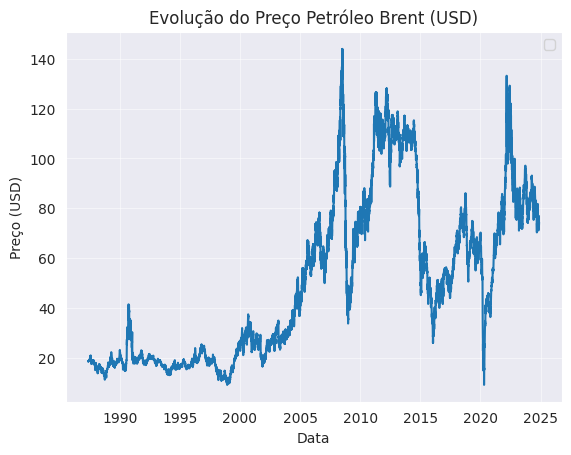

In [ ]:
plt.plot(df['ds'], df['y'])
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.title('Evolução do Preço Petróleo Brent (USD)')
plt.grid(True, linestyle='-', alpha=0.5)
plt.legend()
plt.show()

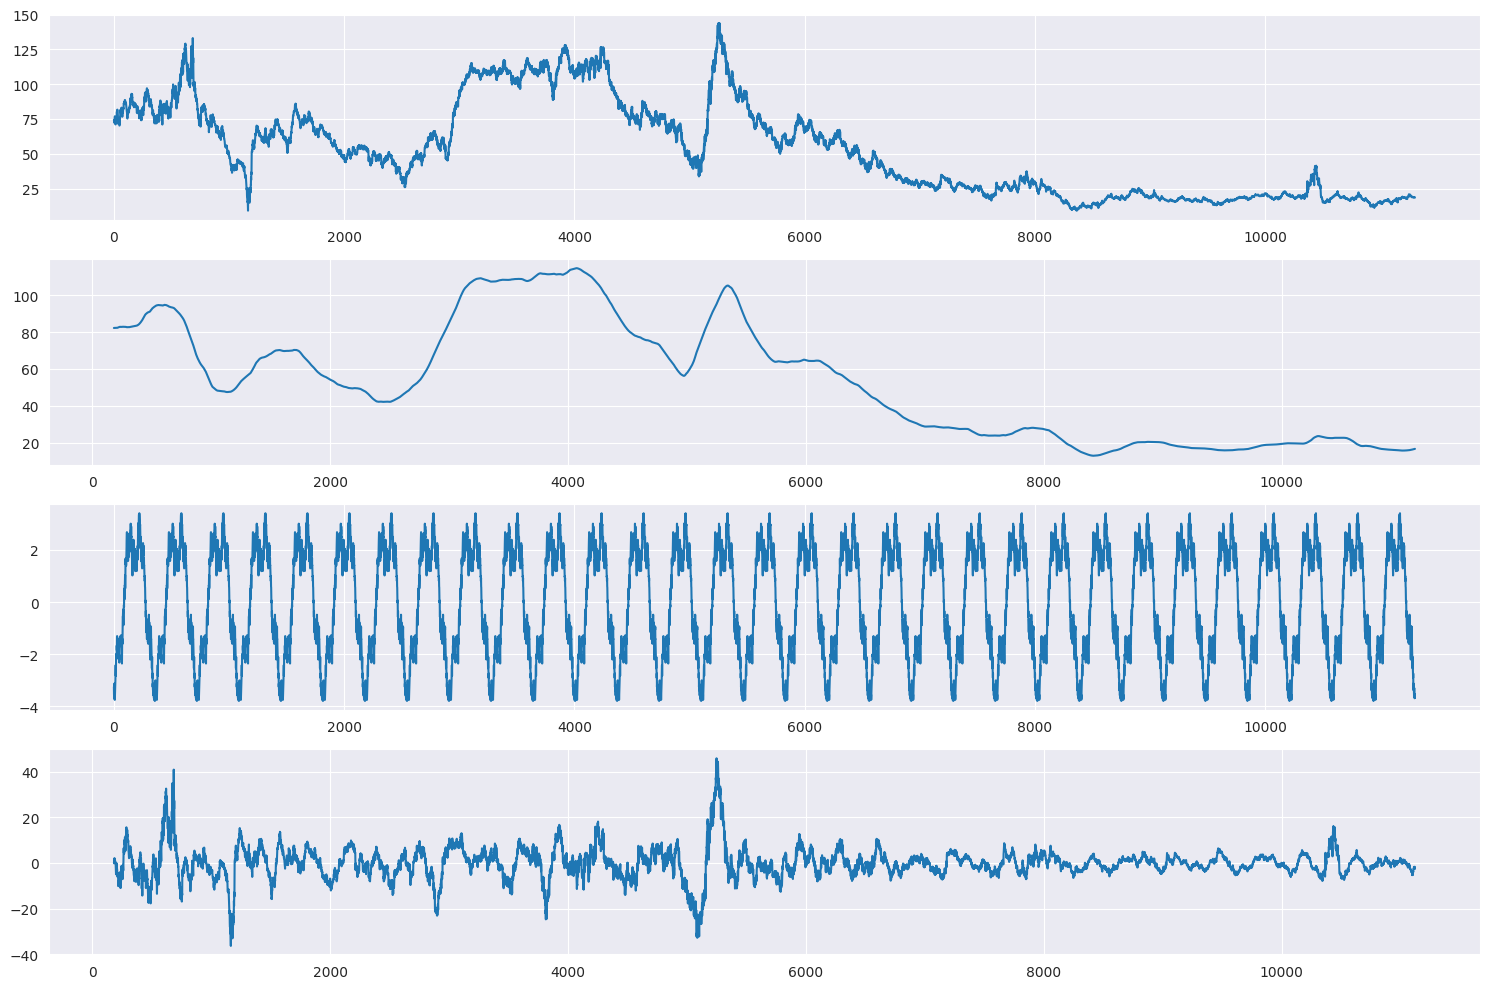

In [ ]:
periodo = 365
resultados = seasonal_decompose(df['y'], period=periodo)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()
plt.show()

In [ ]:
#Verificando se a série temporal é estacionária ou não estacionária

#ADF - Augmented Dickey Fuller
#H0 - Hipótese Nula (não é estacionária)
#H1 - Hipótese Alternativa (rejeição da hipótese nula)
# p-value = 0.05 (5%), então rejeitamos H0 com um nível de confiança de 95%

sns.set_style('darkgrid')

X = df.y.values

result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"Valor-p:{result[1]}")
print("Valores Críticos:")

for key, value in result[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.131176640028584
Valor-p:0.2321644712640175
Valores Críticos:
	1%: -3.4309303717893864
	5%: -2.8617964929904978
	10%: -2.5669065261087654


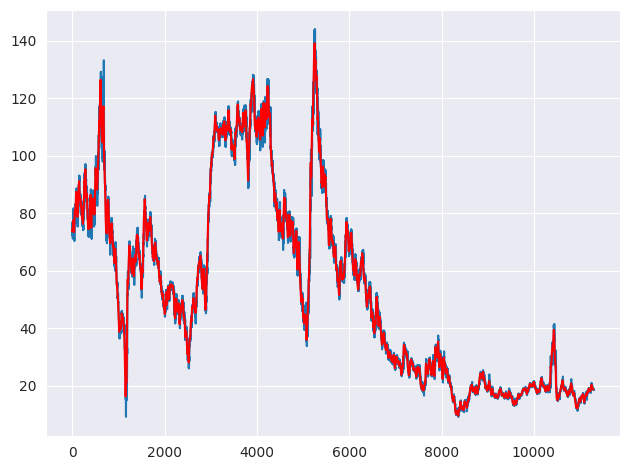

In [ ]:
ma = df.y.rolling(12).mean()

f, ax = plt.subplots()
df.y.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()
plt.show()

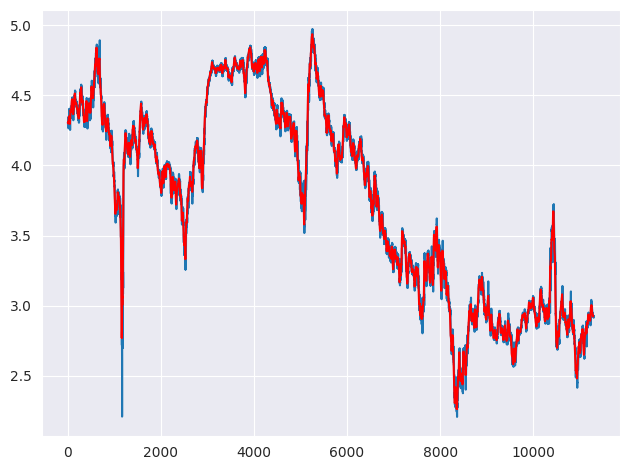

In [ ]:
df_log = np.log(df.y)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()
plt.show()

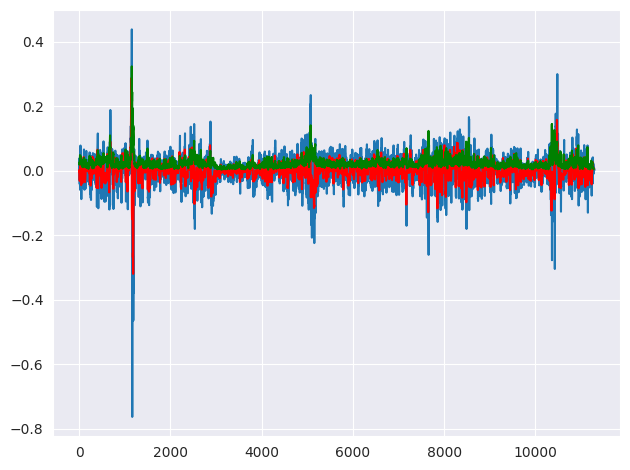

In [ ]:
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt. tight_layout()
plt.show()

In [ ]:
X_s = df_s.values

result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"Valor-p:{result_s[1]}")
print("Valores Críticos:")

for key, value in result_s[4].items():
    print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -17.79499338249383
Valor-p:3.235539488887349e-30
Valores Críticos:
	1%: -3.4309306810067857
	5%: -2.8617966296345316
	10%: -2.5669065988439765


Teste ADF
Teste Estatístico: -24.70213793343601
P-Value: 0.0
Valores críticos:
	1%: -3.4309314554937558
	5%: -2.8617969718824283
	10%: -2.5669067810215207


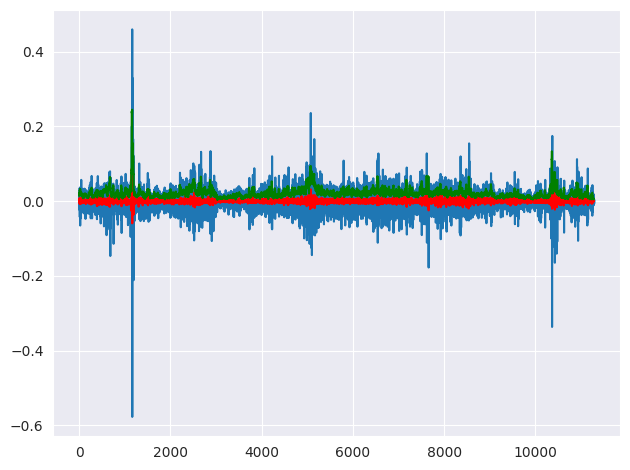

In [ ]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()

std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt. tight_layout()

X_diff = df_diff.dropna().values
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

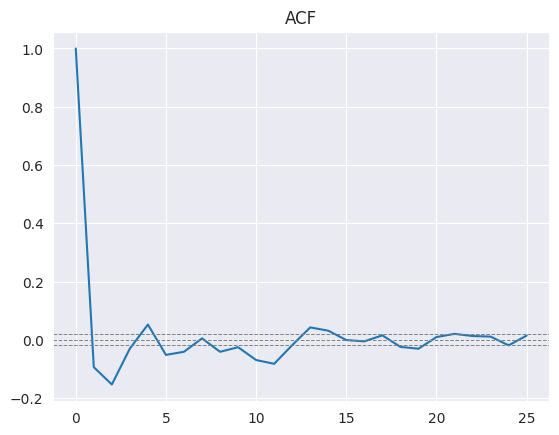

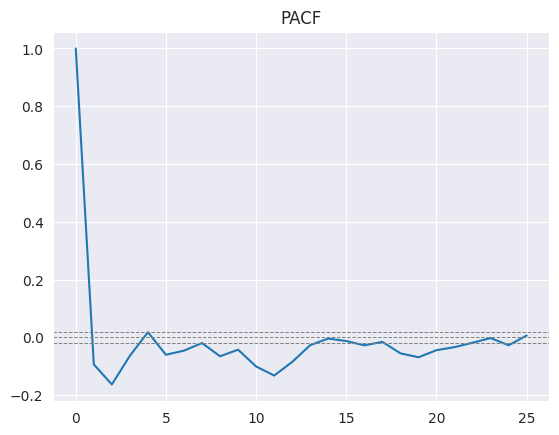

In [ ]:
#Verificando o ACF e PACF

lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)



plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("PACF")
plt.show()

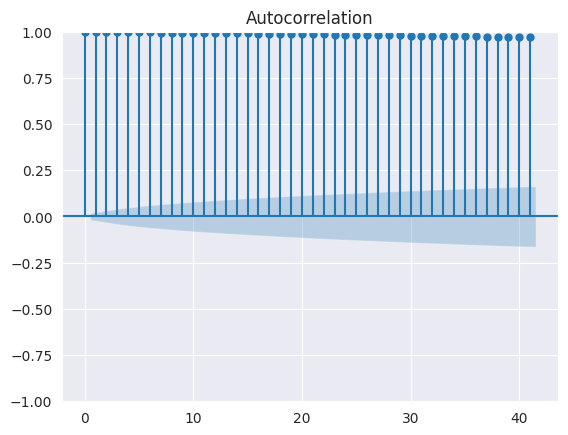

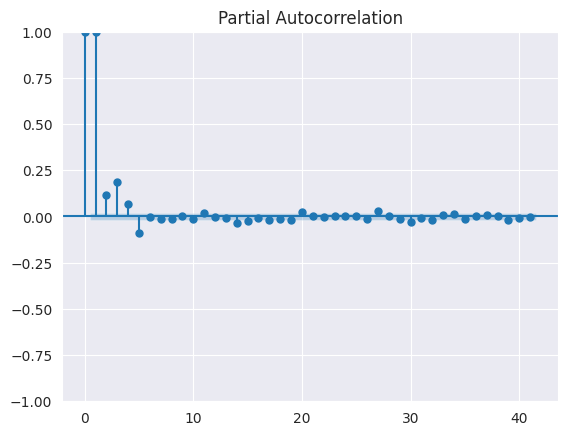

In [ ]:
plot_acf(df.y)
plot_pacf(df.y)

plt.show()

### Modelo: Prophet

In [ ]:
train = df.iloc[:-365]
test = df.iloc[-365:]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1np2pzml/1itjgnov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1np2pzml/kw40sx_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49295', 'data', 'file=/tmp/tmp1np2pzml/1itjgnov.json', 'init=/tmp/tmp1np2pzml/kw40sx_5.json', 'output', 'file=/tmp/tmp1np2pzml/prophet_modelbzaqp6l7/prophet_model-20241201011123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:11:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:11:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(0.5, 1.0, 'Prophet')

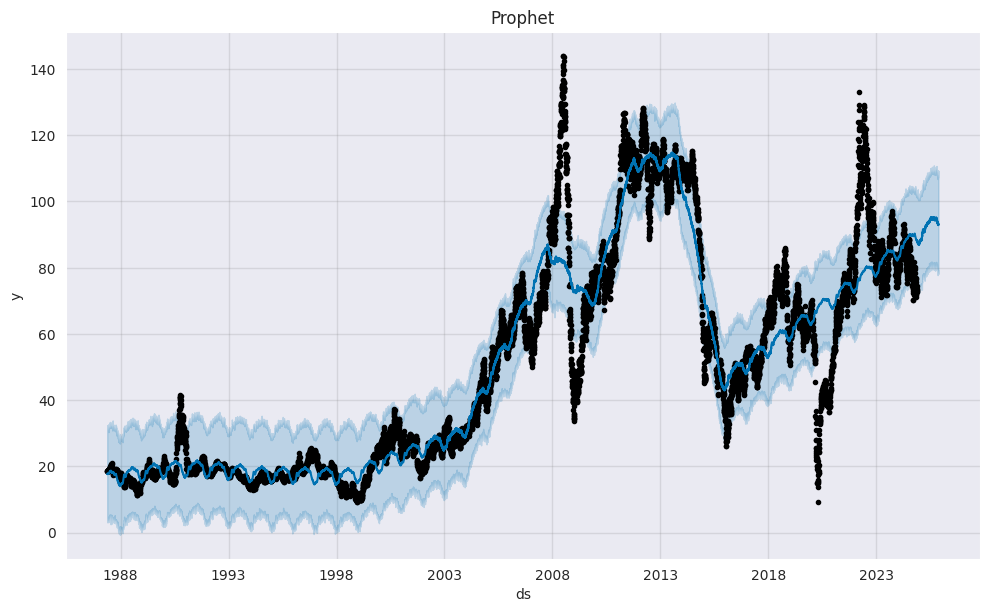

In [ ]:
#De acordo com as caracteristicas, o modelo selecionado foi o Prophet
m = Prophet(weekly_seasonality = True)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

m.plot(forecast)
plt.title("Prophet")

In [ ]:
predictions = forecast.iloc[-365:]['yhat']

In [ ]:
#Analisando as métricas do modelo
print("RMSE: ", rmse(predictions, test['y']))
print("MAE: ", mean_absolute_error(predictions, test['y']))
std_dev = df['y'].std()
print(f"O desvio padrão do preço do petróleo é: {std_dev}")

RMSE:  12.037995654923884
MAE:  10.571940170632733
O desvio padrão do preço do petróleo é: 33.155847481341034


Analisando o RMSE e MAE é possível verificar que ele é menor que o Desvio Padrão, sendo um bom modelo para o caso.

###Exportando o modelo para a Aplicação do Streamlit

In [ ]:
joblib.dump(m, 'modelo_prophet.pkl')

['modelo_prophet.pkl']